In [2]:
# Set project directory
import os
import sys


def project_dir():
    notebook_path = %pwd
    repo_name = "sisi"
    repo_folder = notebook_path.split(repo_name)[0]
    return os.path.join(repo_folder, repo_name)


pwd = os.getenv("PWD", project_dir())
os.environ["PWD"] = pwd
sys.path.append(pwd)

In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from Utils.data_utils import load_train_test_data_eu
from matplotlib import pyplot as plt
from pandas import Timestamp
import pickle
import warnings
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)

In [4]:
(train_list, test_list), state_list = load_train_test_data_eu(pwd)

In [6]:
#Creating lag value for each state '''probably not needed'''
for i in range(len(train_list)):
    train_list[i]['lag1'] = train_list[i]['carbon_per_MWh'].shift(24)
    train_list[i] = train_list[i].dropna()
    
for i in range(len(test_list)):
    test_list[i]['lag1'] = test_list[i]['carbon_per_MWh'].shift(24)
    test_list[i] = test_list[i].dropna()

In [7]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

In [8]:
predictions = []
errors = []
for train, test in zip(train_list, test_list):
    train_features = np.array(train['lag1'])
    train_labels = np.array(train['carbon_per_MWh'])
    test_features = np.array(test['lag1'])
    test_labels = np.array(test['carbon_per_MWh'])
    rf.fit(train_features.reshape(-1,1), train_labels)
    prediction = rf.predict(test_features.reshape(-1,1))
    predictions.append(prediction)
    errors.append(abs(prediction - test_labels))

In [14]:
for state, error in zip(state_list, errors):
    print(f"MAE for {state} = {np.mean(error)}")

MAE for FI = 30.815793368201746
MAE for ES = 34.81543986033521
MAE for IT = 36.52998877986043
MAE for DK = 108.62260983805545
MAE for PL = 80.06313209083153
MAE for FR = 12.244684298813262
MAE for SE = 0.013960820232150267
MAE for CZ = 32.875405832631884
MAE for CH = 0.0


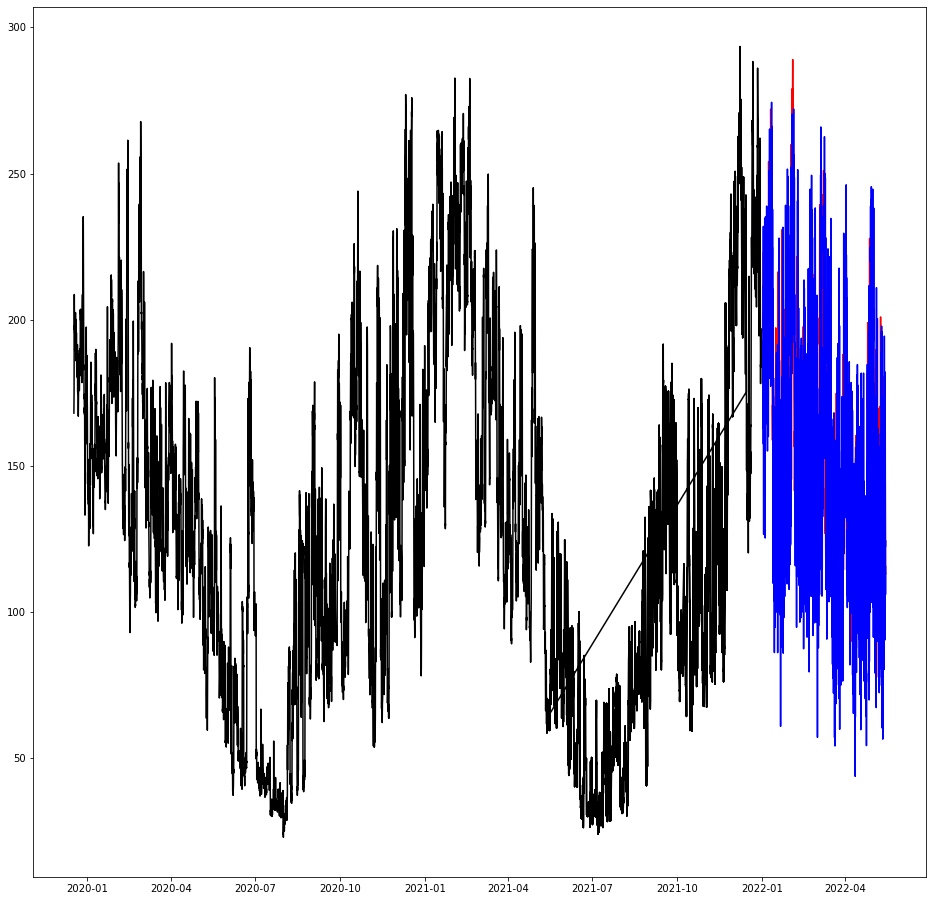

In [9]:
plt.figure(figsize=(16,16))
plt.plot(train_list[0].index, train_list[0]['carbon_per_MWh'], color='black')
plt.plot(test_list[0].index, test_list[0]['carbon_per_MWh'], color='red')
plt.plot(test_list[0].index, predictions[0], color='blue')

In [17]:
hour_dict_list = []
for i in range(len(test_list)):
    hour_dict = {test_list[i].index[j] : predictions[i][j] for j in range(len(predictions[i]))}
    hour_dict_list.append(hour_dict)

In [19]:
file = open(f'{pwd}/data/predictions/rfpred_eu.pkl', 'wb')
pickle.dump(hour_dict_list, file)
file.close()
file2 = open(f'{pwd}/data/predictions/country_list_eu.pkl', 'wb')
pickle.dump(state_list, file2)
file2.close()